# Importar librerias

In [59]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

## Importar funciones personalizadas

In [46]:
%run pandas-missing-extension.ipynb

## Cargar los datos de NHANES

In [47]:
nhanes_raw_df = nhanes.load.load_NHANES_data(year="2017-2018")
nhanes_raw_df

,GeneralHealthCondition,EverBreastfedOrFedBreastmilk,AgeStoppedBreastfeedingdays,AgeFirstFedFormuladays,AgeStoppedReceivingFormuladays,AgeStartedOtherFoodbeverage,AgeFirstFedMilkdays,TypeOfMilkFirstFedWholeMilk,TypeOfMilkFirstFed2Milk,TypeOfMilkFirstFed1Milk,...,DaysSmokedCigsDuringPast30Days,AvgCigarettesdayDuringPast30Days,TriedToQuitSmoking,TimesStoppedSmokingCigarettes,HowLongWereYouAbleToStopSmoking,UnitOfMeasureDayweekmonthyear_2_SMQ,CurrentSelfreportedHeightInches,CurrentSelfreportedWeightPounds,TriedToLoseWeightInPastYear,TimesLost10LbsOrMoreToLoseWeight
SEQN,,,,,,,,,,,,,,,,,,,,,
93703.0,NaN,1.0,273.0,1.0,365.0,152.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93704.0,NaN,1.0,60.0,3.0,365.0,126.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93705.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,63.0,165.0,0.0,11 times or more
93706.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68.0,145.0,0.0,Never
93707.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102952.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.0,0.0,Never
102953.0,Fair or,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,65.0,218.0,0.0,Never
102954.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,66.0,150.0,0.0,Never


In [48]:
missing_values = nhanes_raw_df.isna().sum()
print(missing_values)

GeneralHealthCondition                 2402
EverBreastfedOrFedBreastmilk           7297
AgeStoppedBreastfeedingdays            7504
AgeFirstFedFormuladays                 7289
AgeStoppedReceivingFormuladays         7475
                                       ... 
UnitOfMeasureDayweekmonthyear_2_SMQ    7870
CurrentSelfreportedHeightInches        2590
CurrentSelfreportedWeightPounds        2538
TriedToLoseWeightInPastYear            3279
TimesLost10LbsOrMoreToLoseWeight       2572
Length: 197, dtype: int64


## Procesar los datos de NHANES

In [49]:
nhanes_df = (
    nhanes_raw_df.select_columns(
        "GeneralHealthCondition",
        "AgeInYearsAtScreening",
        "Gender",
        "CurrentSelfreportedHeightInches",
        "CurrentSelfreportedWeightPounds",
        "DoctorToldYouHaveDiabetes",
        "60SecPulse30SecPulse2",
        "TotalCholesterolMgdl"
    )
    .rename_columns(
        {
            "AgeInYearsAtScreening":"age",
            "CurrentSelfreportedHeightInches":"height",
            "CurrentSelfreportedWeightPounds":"weight",
            "DoctorToldYouHaveDiabetes":"diabetes",
            "60SecPulse30SecPulse2":"pulse",
            "TotalCholesterolMgdl":"total_cholesterol",
            "GeneralHealthCondition":"general_health_condition",
            "Gender": "gender"
        }
    )
    .replace(
        {
            "height": {
                9999: np.nan,
                7777: np.nan
            },
            "weight": {
                9999: np.nan,
                7777: np.nan
            },
            "diabetes": {
                "Borderline": np.nan
            }
        }
    )
    .missing.sort_variables_by_missingness()
    .dropna(
        subset = ["diabetes"],
        how = "any"
    )
    .transform_column(
        column_name = "diabetes",
        function = lambda s: s.astype(int),
        elementwise = False
    )
)

d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


In [50]:
nhanes_df

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,gender,age
SEQN,,,,,,,,
93703.0,NaN,NaN,NaN,NaN,NaN,0,Female,2.0
93704.0,NaN,NaN,NaN,NaN,NaN,0,Male,2.0
93705.0,63.0,165.0,Good,157.0,52.0,0,Female,66.0
93706.0,68.0,145.0,Very good,148.0,82.0,0,Male,18.0
93707.0,NaN,NaN,Good,189.0,100.0,0,Male,13.0
...,...,...,...,...,...,...,...,...
102951.0,NaN,NaN,NaN,NaN,NaN,0,Male,4.0
102953.0,65.0,218.0,Fair or,182.0,78.0,0,Male,42.0
102954.0,66.0,150.0,Good,172.0,78.0,0,Female,41.0


## Visualizar los valores faltantes

<Axes: >

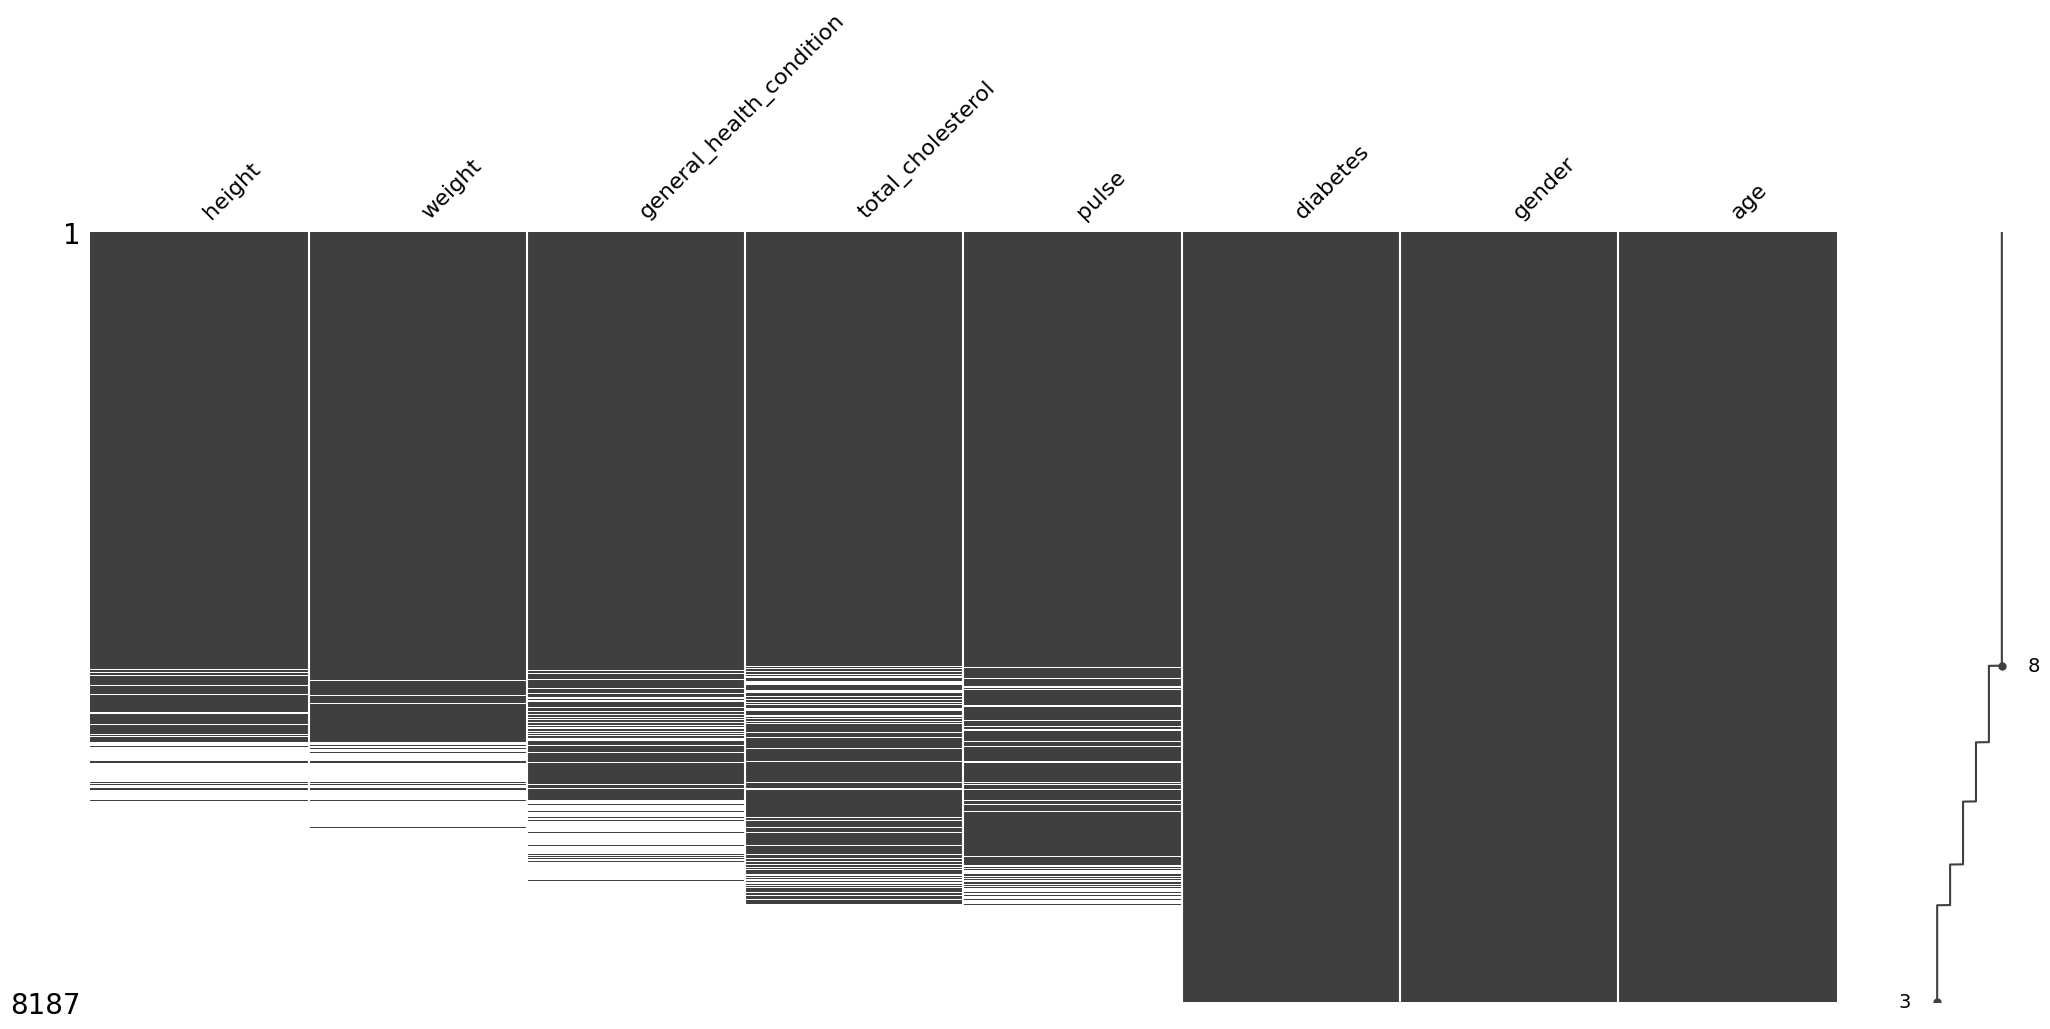

In [51]:
nhanes_df.missing.sort_variables_by_missingness().pipe(missingno.matrix, sort="descending")

d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\upsetplot\plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will nev

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

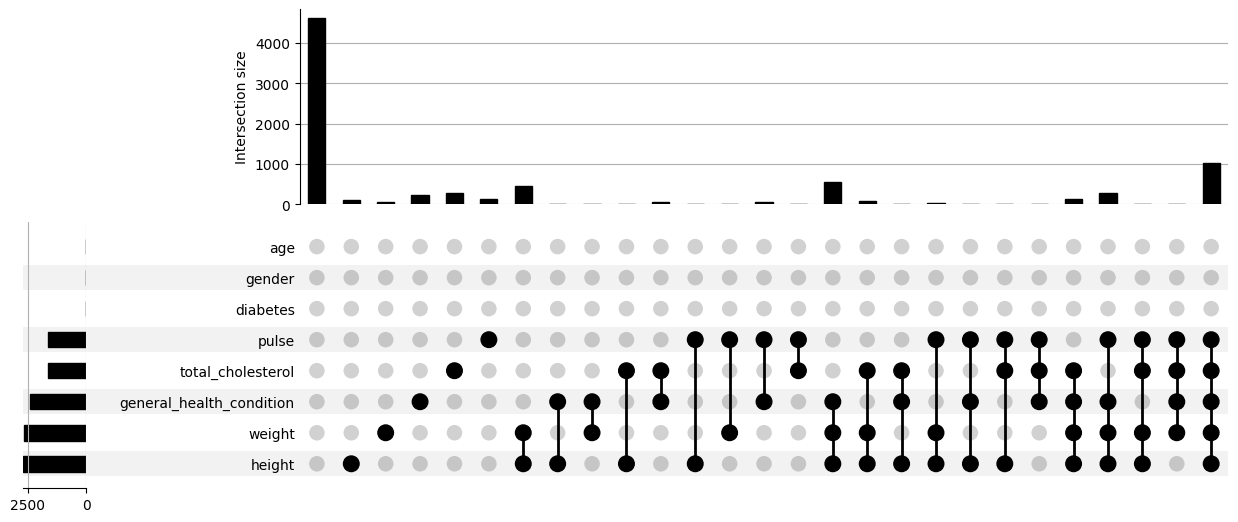

In [52]:
(
    nhanes_df
    .missing.sort_variables_by_missingness()
    .missing.missing_upsetplot()        
)

<Axes: >

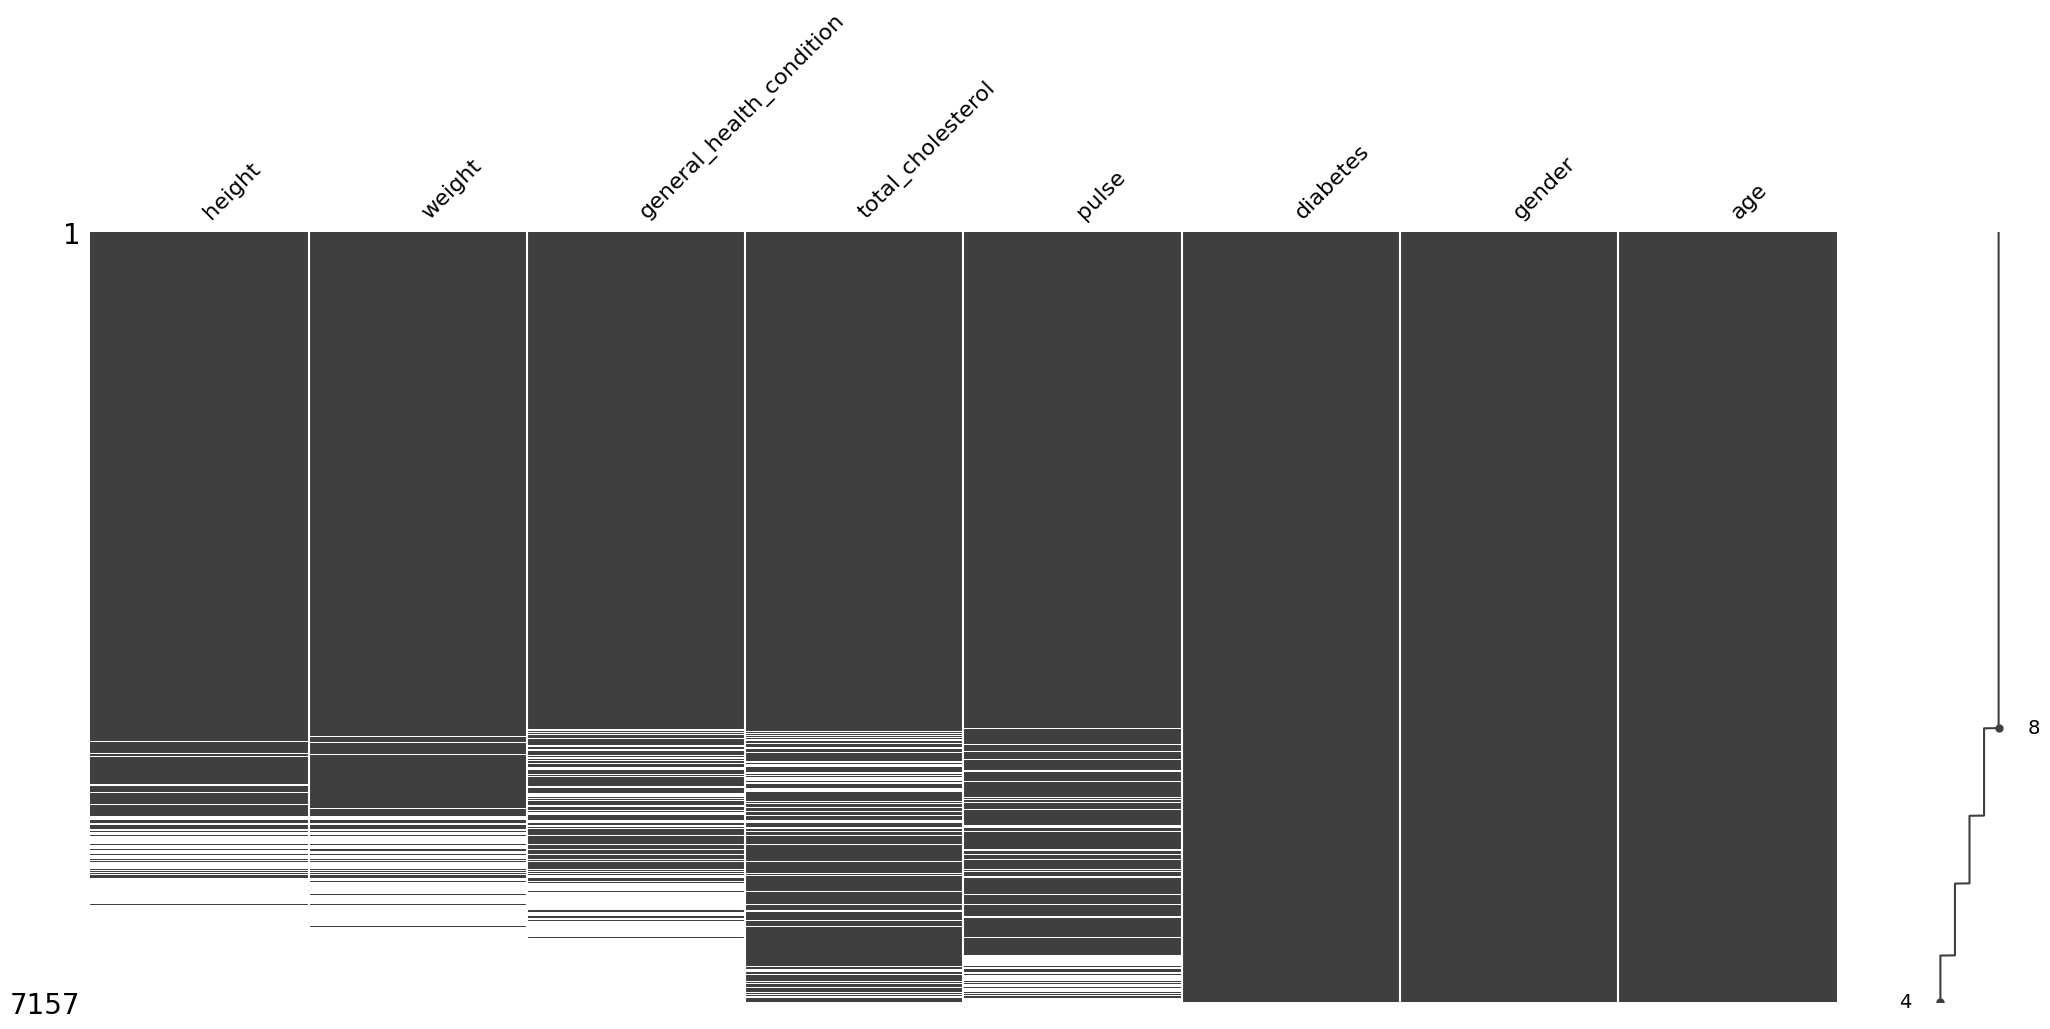

In [53]:
(
    nhanes_df.dropna(
        subset = ["pulse", "total_cholesterol", "general_health_condition", "weight", "height"],
        how = "all"
    )
    .missing.sort_variables_by_missingness()
    .pipe(missingno.matrix, sort="descending")
)

## Eliminar valores faltantes

In [54]:
nhanes_df = (
    nhanes_df.dropna(
        subset = ["pulse", "total_cholesterol", "general_health_condition", "weight", "height"],
        how = "all"
    )
    .missing.sort_variables_by_missingness()
)

nhanes_df.shape

(7157, 8)

## Consideracion y evaluacion de los distintos tipos de valores faltantes

In [44]:
female_weight, male_weight = (
    nhanes_df
    .select_columns("gender", "weight")
    .transform_column("weight", lambda x: x.isna(), elementwise = False)
    .groupby("gender")
    .weight
    .pipe(
        lambda df: (
            df.get_group("Female"),
            df.get_group("Male")
        )
    )
)

scipy.stats.ttest_ind(
    a = female_weight,
    b = male_weight,
    alternative = "two-sided"
)

d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


TtestResult(statistic=np.float64(inf), pvalue=np.float64(nan), df=np.float64(-1.0))

## Ampliar el conjunto de herramientas para explorar valores faltantes

d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


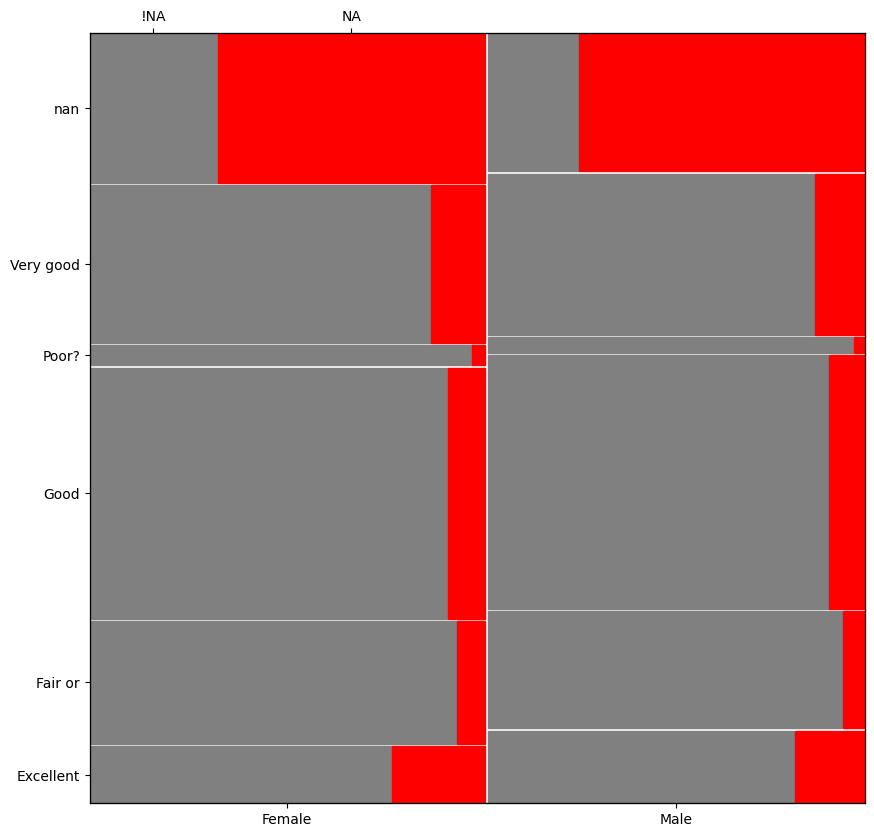

In [62]:
fig, ax = plt.subplots(figsize=(10,10))

(
    nhanes_df
    .select_columns('weight','general_health_condition','gender')
    .assign(
        weight=lambda df: df.weight.isna().replace([True, False], ['NA', '!NA'])
    )
    .groupby(
        ['gender','general_health_condition','weight'],
        dropna=False,
        as_index = True
    )
    .size()
    .pipe(
        lambda df: mosaic(
            data = df,
            properties=lambda key: {'color':'r' if 'NA' in key else 'gray'},
            horizontal=True,
            axes_label=True,
            title='',
            labelizer=lambda key: '',
            ax = ax
        )
    )
);